In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# 1. Library Imports

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


# 2. Load Dataset

In [73]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Dataset Loaded Successfully.")

Dataset Loaded Successfully.


In [74]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 3. Exploratory Data Analysis (EDA)

In [75]:
print(df.head())
print(df.info())
print(df.describe())

# Object column value counts
for col in df.columns:
    if df[col].dtypes == "object":
        print(f"Column: {col}")
        print(df[col].value_counts())
        print('-'*40)


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [76]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

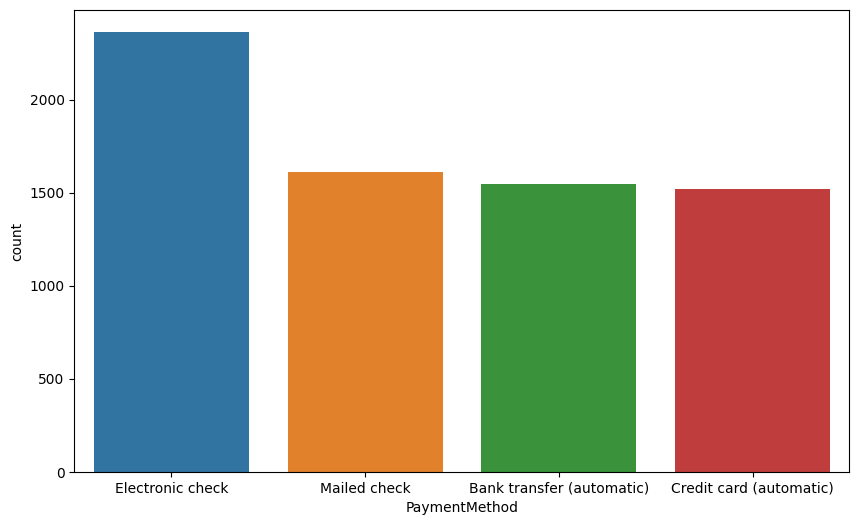

In [77]:
# Count plot
plt.figure(figsize=(10, 6))
sns.countplot(x="PaymentMethod", data=df)
plt.show()


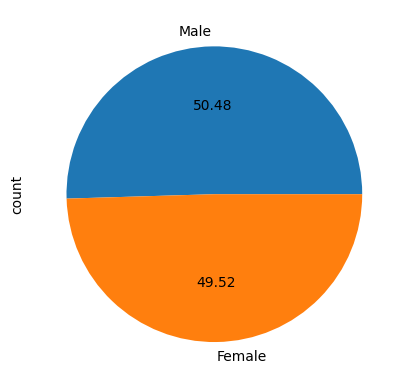

In [78]:
# Pie chart
df['gender'].value_counts().plot(kind='pie', autopct='%.2f')
plt.show()

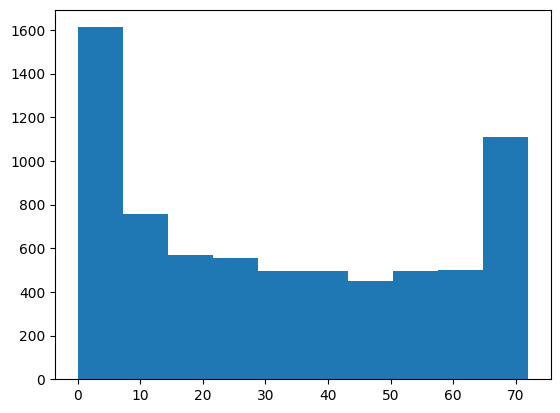

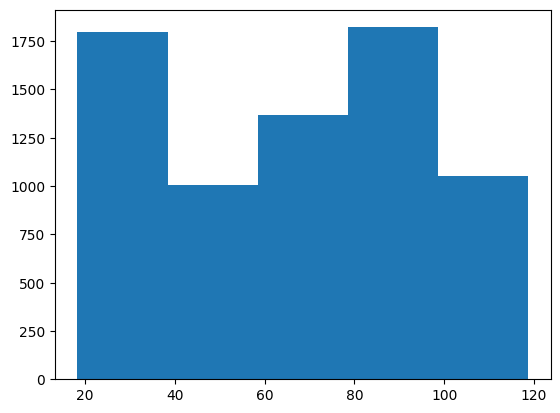

In [79]:
# Histograms
plt.hist(df['tenure'])
plt.show()

plt.hist(df['MonthlyCharges'], bins=5)
plt.show()

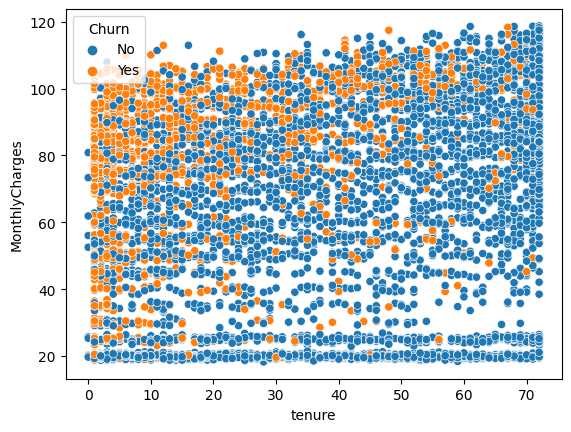

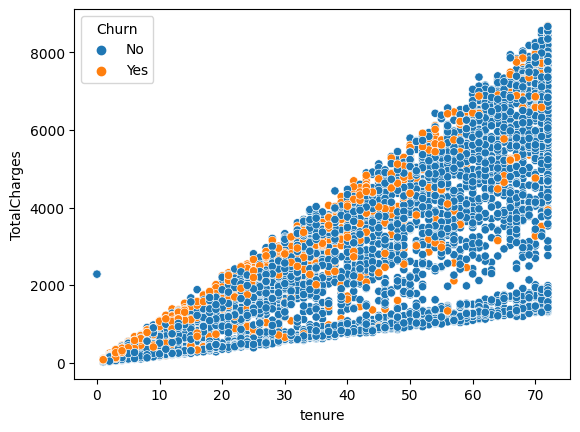

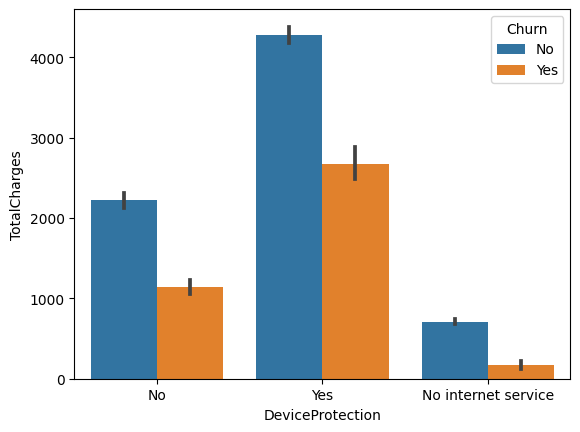

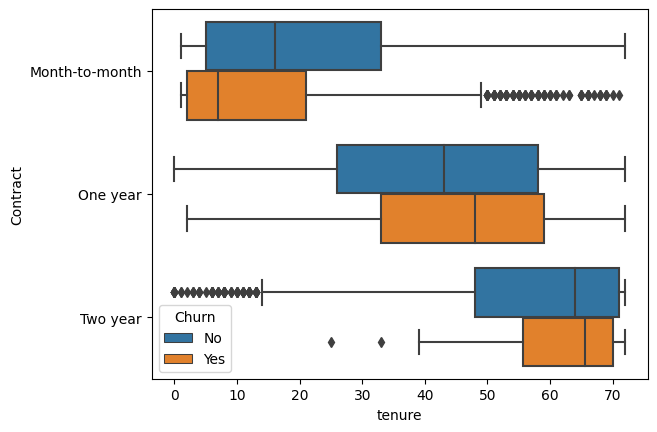

In [80]:
# Scatter and Bar plots
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn')
plt.show()

sns.scatterplot(data=df, x='tenure', y='TotalCharges', hue='Churn')
plt.show()

sns.barplot(data=df, x='DeviceProtection', y='TotalCharges', hue='Churn')
plt.show()

sns.boxplot(data=df, x='tenure', y='Contract', hue='Churn')
plt.show()

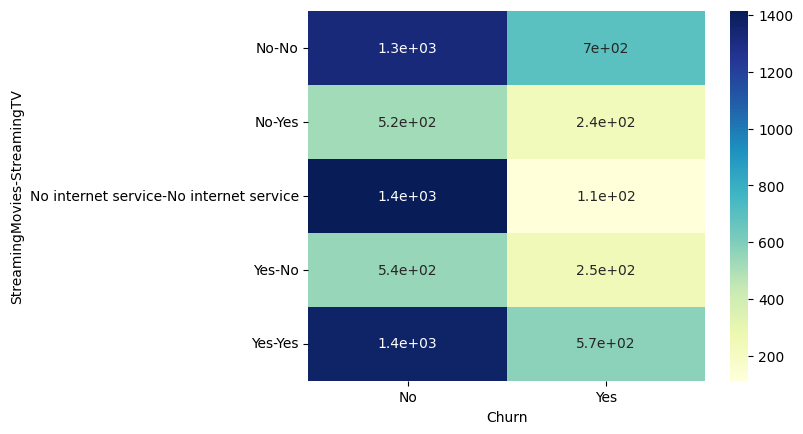

In [81]:
# Crosstab Heatmap
cross_tab = pd.crosstab(index=[df['StreamingMovies'], df['StreamingTV']], columns=df['Churn'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu')
plt.show()

# 4. ydata_profiling

In [82]:
!pip install ydata_profiling

In [83]:
from ydata_profiling import ProfileReport

# Create a profile report
profile = ProfileReport(df, title="EDA Report", explorative=True)

# To save the report to an HTML file
profile.to_file("eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 23.60it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 5. Data Cleaning

In [84]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Encode categorical columns
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Check duplicates
print("Duplicates:", df.duplicated().sum())

Duplicates: 22


In [85]:
df.drop_duplicates(inplace=True)
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


# 6. Model Training & Evaluation

In [86]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

result_df = pd.DataFrame(results, columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print(result_df)


                    Model  Accuracy
0     Logistic Regression  0.787900
1           Random Forest  0.787189
4     K-Nearest Neighbors  0.767260
5                 XGBoost  0.765836
3  Support Vector Machine  0.749466
2           Decision Tree  0.734520


# 7. Ensemble Voting Classifier (Top 3 Models)

In [87]:
model1 = LogisticRegression(max_iter=1000)
model2 = RandomForestClassifier()
model3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

voting_classifier = VotingClassifier(estimators=[
    ('lr', model1), 
    ('rf', model2), 
    ('xgb', model3)], 
    voting="soft")

voting_classifier.fit(X_train, y_train)
y_pred = voting_classifier.predict(X_test)
ensemble_acc = accuracy_score(y_test, y_pred)

print("Voting Classifier Accuracy:", ensemble_acc)


Voting Classifier Accuracy: 0.79644128113879


# End to End PipeLine

In [95]:
# 1. Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [96]:
# load and prepare data 

df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
df.drop('customerID', axis=1, inplace=True)

# Separate target
X = df.drop("Churn", axis=1)
y = df["Churn"]


In [97]:
# Pipeline Processing
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [98]:
y = LabelEncoder().fit_transform(y)

In [99]:
# Create a Processor
from sklearn.preprocessing import OneHotEncoder

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])


In [100]:
# creating model pipeline
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [101]:
 # Train and Evaluate Pipelines
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {acc:.4f}")


Logistic Regression: Accuracy = 0.8219
Random Forest: Accuracy = 0.7928
Decision Tree: Accuracy = 0.7111
Support Vector Machine: Accuracy = 0.8098
KNN: Accuracy = 0.7729
XGBoost: Accuracy = 0.7984


In [102]:
# Define individual pipelines
lr = Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))])
rf = Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
xgb = Pipeline([('preprocessor', preprocessor), ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

# Voting Classifier (use only final estimators)
voting = VotingClassifier(estimators=[
    ('lr', lr.named_steps['classifier']),
    ('rf', rf.named_steps['classifier']),
    ('xgb', xgb.named_steps['classifier']),
], voting='soft')

# Fit using transformed data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
voting.fit(X_train_transformed, y_train)
y_pred = voting.predict(X_test_transformed)

print("\nVoting Classifier Accuracy:", accuracy_score(y_test, y_pred))


Voting Classifier Accuracy: 0.8076650106458482
